In [1]:
import tensorflow as tf

if tf.test.is_gpu_available():
    device = '/GPU:0'
    print("GPU Available")
else:
    device = '/CPU:0'
    print("CPU Available")

GPU Available


In [2]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

plt.style.use('fivethirtyeight')

In [4]:
class CFG:
    imdim1 = 20
    imdim2 = 10

\begin{equation}
X_t = T_t + S_t + C_t + \epsilon_t 
\end{equation}

Deterministic Components:            
T : Trend   
S : Seasonality     
C : Cycle (Like Economic Cycle)

In Seasonal: we know the period,            
whereas in the cyclical: we dont know the period

In [5]:
df = pd.read_csv("./archive/us_energy.csv")
df.head()

,date,value
0,1973-01-01,160.218
1,1973-01-31,143.539
2,1973-03-02,148.158
3,1973-04-02,139.589
4,1973-05-02,147.395


        date    value
0 1973-01-01  160.218
1 1973-01-31  143.539
2 1973-03-02  148.158
3 1973-04-02  139.589
4 1973-05-02  147.395


<AxesSubplot:xlabel='date'>

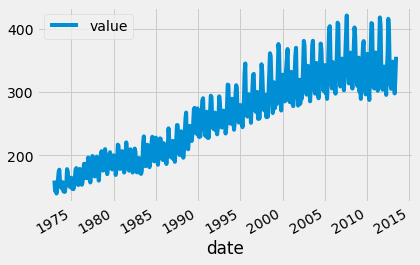

In [6]:
df['date'] = pd.to_datetime(df['date'])
print(df.head())
df.set_index('date',inplace=True)
df.plot()

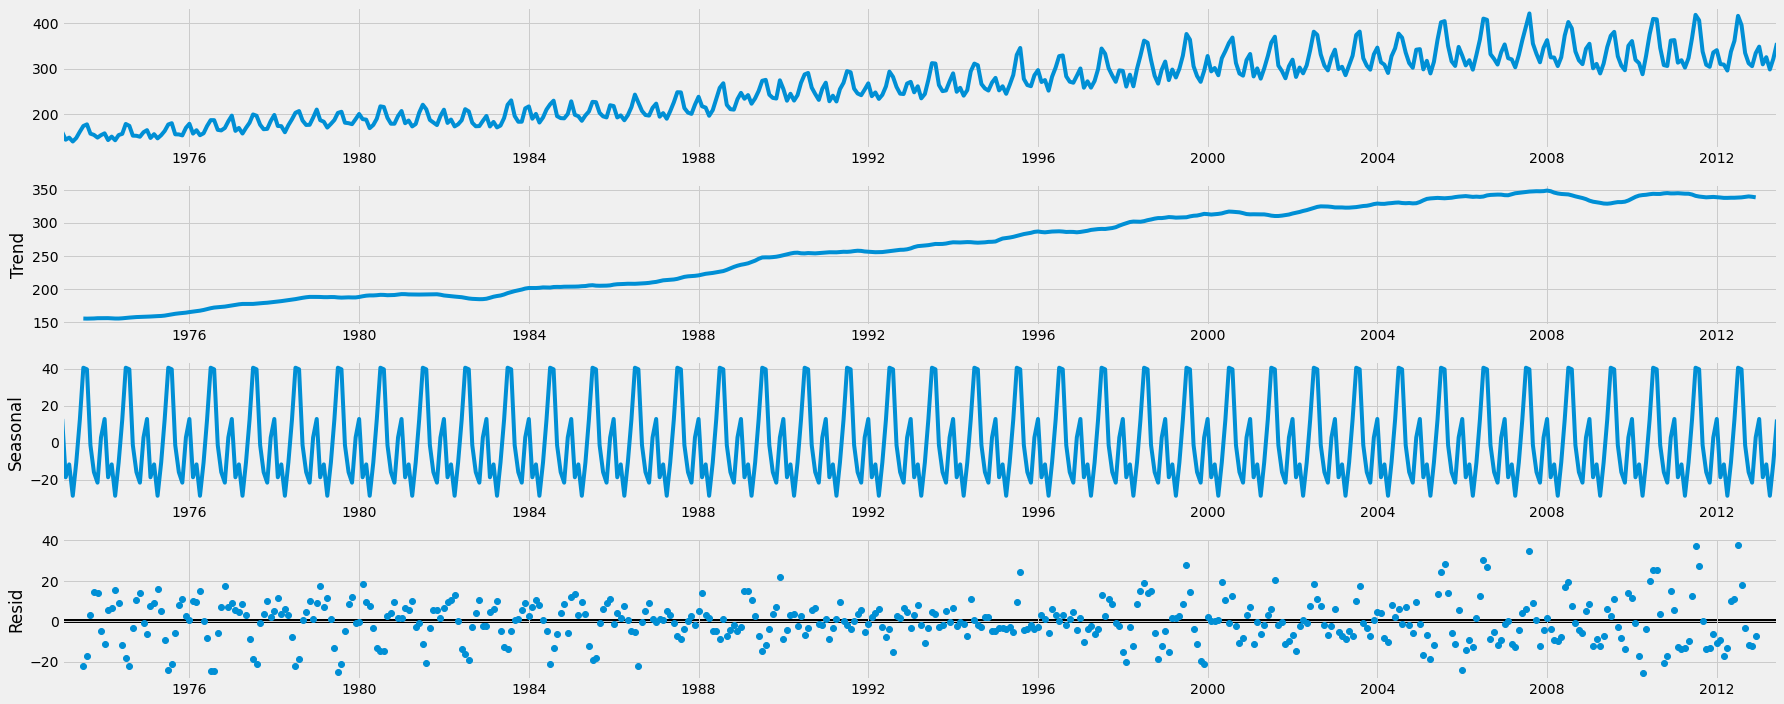

In [7]:
 ## lets decompose the data into trend (T), seasonality (S) and reminder (Et)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, period=12)
## period = 12, since yearly data

from pylab import rcParams
rcParams['figure.figsize'] = 25, 10

figure = decomposition.plot()
plt.show()


c:\Users\Shankii\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


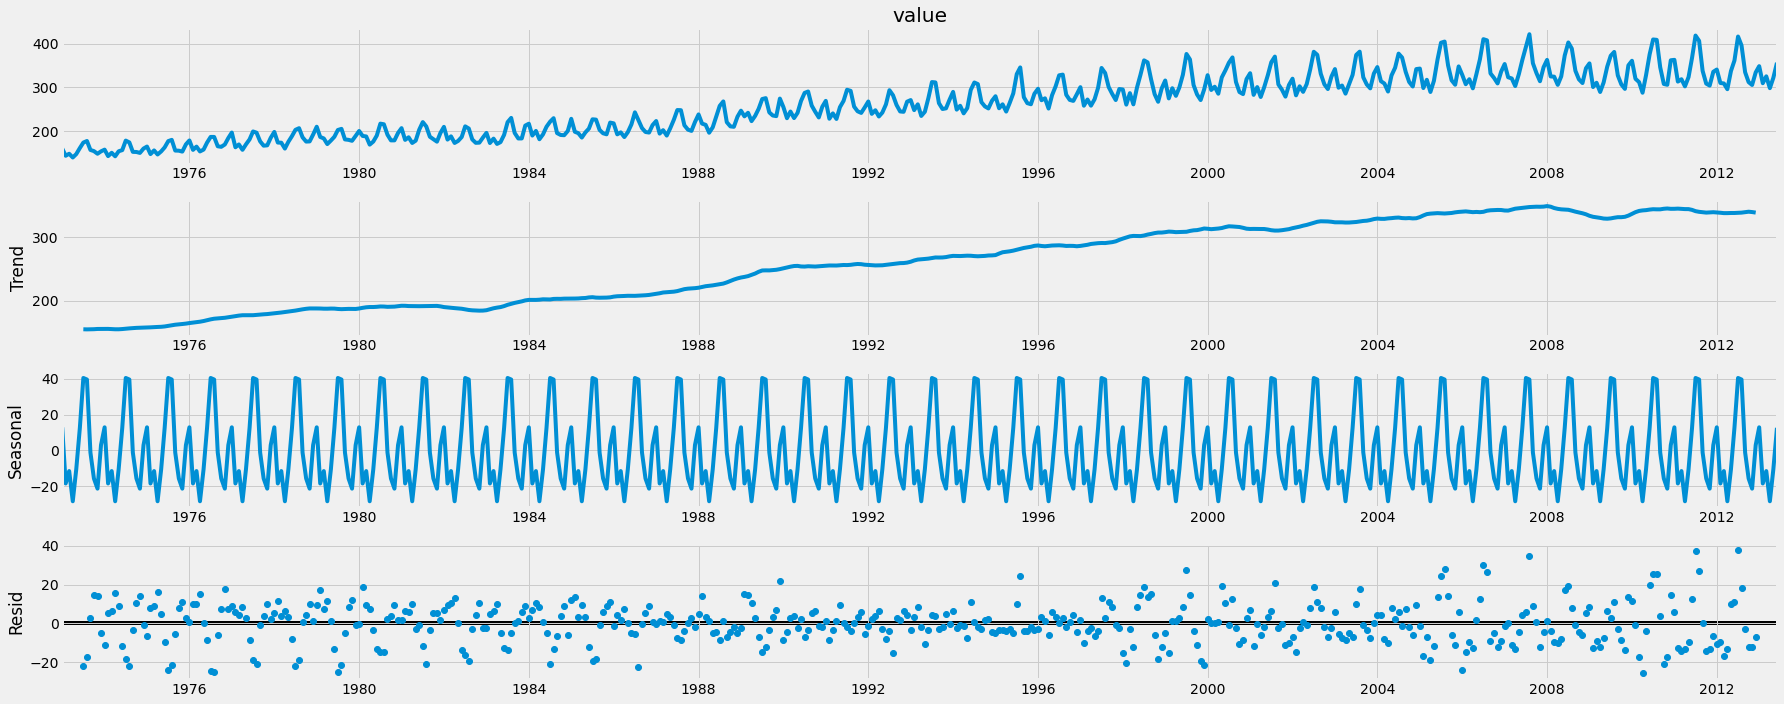

In [10]:
decomposition = seasonal_decompose(df['value'], period = 12, model = 'additive')
figure = decomposition.plot()
figure.show()

## also can check with different seasonalities and all
## what model suits the best
## play with the period thing

## Additive vs Multiplicative

when you say that y increases in numbers like sales up by 10,000 : go for additive

When speaking in terms of percentages, go for multiplicative

## ACF:

In this what happens is we will find the correlation how say t-2 affects t0 directly and indirectly. So 3 steps will be involved in this: 

        -- one direct t-2 to t0 
        -- other two as t-2 to t-1 and then t-1 to t0 

So, because of this the pearson score might be too much, So we don't know what thing is contributing to what        



## PACF:

So what it does is, it removes all the indirect paths. Just the single path from t-2 to t0 and we can see how that affects directly.

So thats why PACF is important

    -- PACF: Just the direct effect
    -- ACF: Direct and the indirect effect

\begin{equation}
PACF:
S_t  = \alpha * S_t(-1) + \beta * S_t(-2) + error
\end{equation}


So here beta is the coeff. of t-2 effect on t0

Theres a error band in the PACF graph, so if any values lie in this confidence interval band and is not overshooting, the band, then that time lag has no effect on the current value.

In the PACF: you can see what time periods are contributing and then you can create a auto regressive model with the time lags and coefficients value.

Choose those values of lags which have correlation not in the error band. 

See the equation for auto regressive model

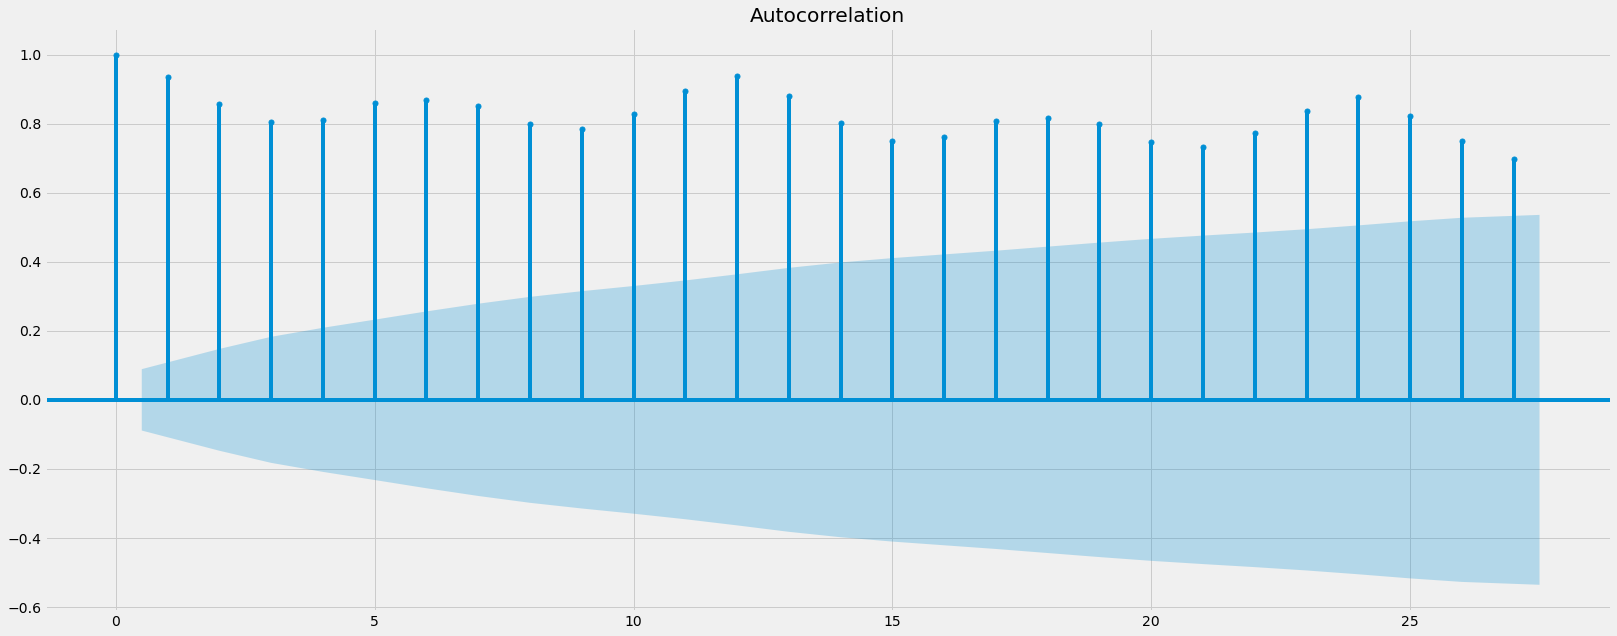

In [8]:
## auto correlation  and partial auto-correlation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['value'])
print()


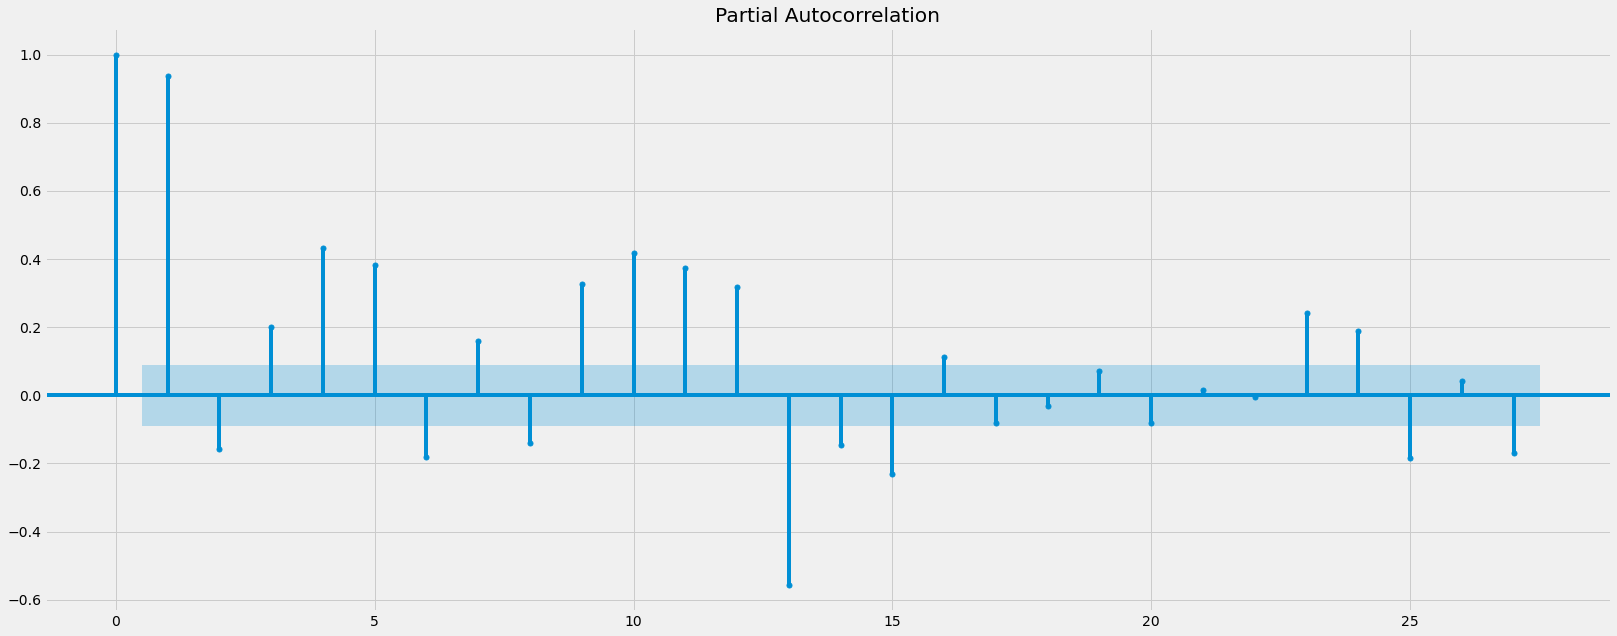

In [9]:
plot_pacf(df['value'])
print()

## so from the PACF graph: t-15 shows the +ve correlation

## Training and Validation

In [10]:
cutoff_data = '2005-12-31'
df['value'] /= 100
xtrain, xvalid = df.loc[df.index <= cutoff_data], df.loc[df.index > cutoff_data]
print(xtrain.shape, xvalid.shape)

(397, 1) (89, 1)


        -- Why do we use exponential smoothing?

Exponential smoothing is generally used to make short term forecasts, but longer-term forecasts using this technique can be quite unreliable. More recent observations given larger weights by exponential smoothing methods, and the weights decrease exponentially as the observations become more distant.


        -- Why is exponential smoothing better than moving average?

Whereas in Moving Averages the past observations are weighted equally, Exponential Smoothing assigns exponentially decreasing weights as the observation get older. In other words, recent observations are given relatively more weight in forecasting than the older observations.

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fit1 = ExponentialSmoothing(xtrain['value'].values, seasonal_periods = 12,
                           trend = 'mul', seasonal='mul',) 

C:\Users\Shankii\anaconda3\envs\gputest\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [12]:
## the model will fit the values: just will replicate the trend
## so we will need just the length of the xvalid as the parameter

fit1 = fit1.fit()
prediction = fit1.forecast(len(xvalid)).copy()

xresiduals = xvalid['value'] - prediction

In [13]:
## parameters for the model

fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,2.817825e-01,True
smoothing_trend,beta,1.888321e-16,True
smoothing_seasonal,gamma,2.263497e-01,True
initial_level,l.0,2.504888e+00,True
initial_trend,b.0,1.001947e+00,True
initial_seasons.0,s.0,6.471523e-01,True
initial_seasons.1,s.1,5.701478e-01,True
initial_seasons.2,s.2,5.853257e-01,True
initial_seasons.3,s.3,5.437786e-01,True
initial_seasons.4,s.4,5.743874e-01,True


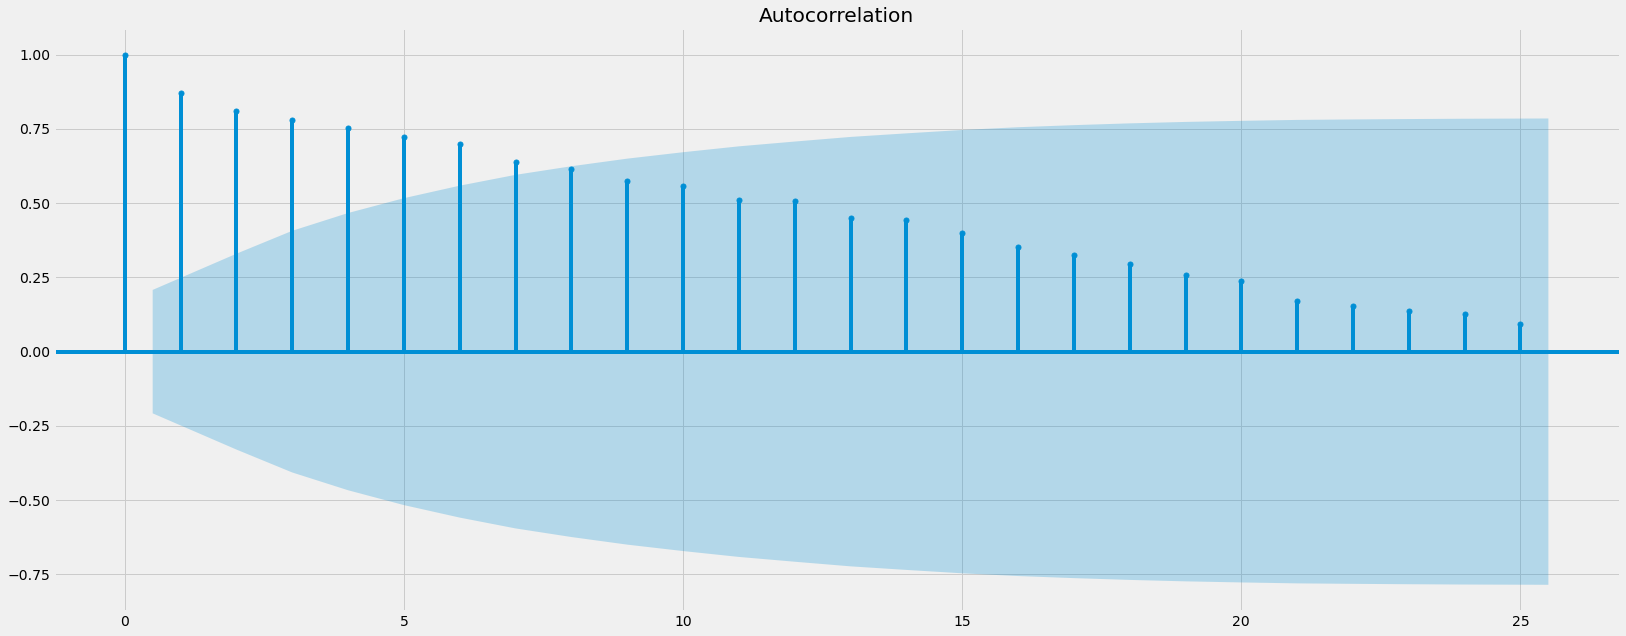

In [14]:
plot_acf(xresiduals, lags = 25)
print()

## residuals decreasing over time

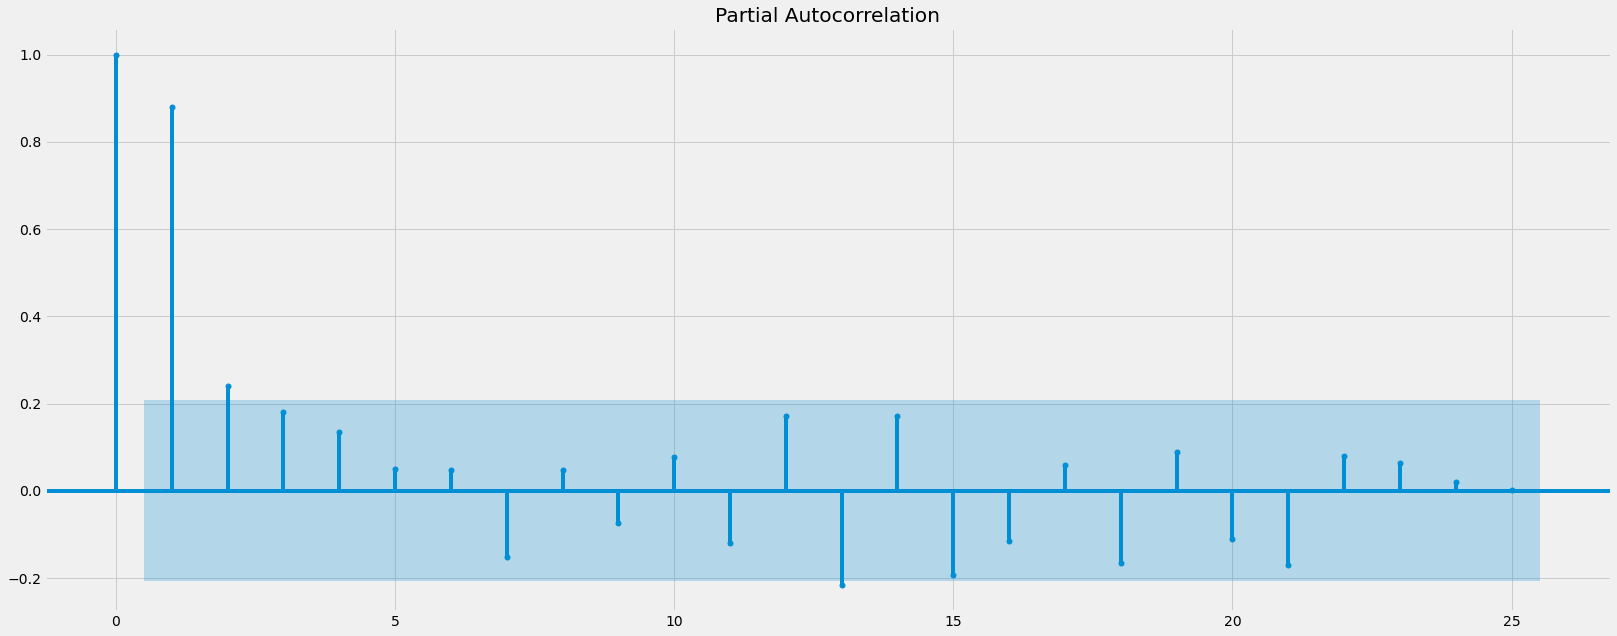

In [15]:
plot_pacf(xresiduals,lags = 25)
print()

## theres still a relationship for one step behind lag
## still the trend in there in it

## Insights

        -- see the acf and pacf, you will clearly see the difference in that. How theres a little correlation between the correlation factors of acf and pacf, just t-1 and t-2 has the larger direct effect on current value and not all the values

## Prophet Model

        -- We dont need to check whether the model is stationary or not before implementing it

In [16]:
from fbprophet import Prophet 
import pandas as pd
xdat  = pd.read_csv('./archive/GreenhouseClimate1/GreenhouseClimate1.csv')
xdat.head()


## really weird timestamp
## its because excel has 5 minutes time stamp and it has origin of 1899-12-30

,time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,0.0,35.000000,439.0,0.48,3.61,96.0,6.96,0.0,50.9,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
1,43815.00347,0.0,85.000001,459.0,0.72,3.61,96.0,7.45,0.0,49.3,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
2,43815.00694,0.0,95.999999,461.0,0.72,3.61,94.6,5.99,0.0,47.6,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
3,43815.01042,0.0,92.000000,465.0,0.72,3.61,94.6,6.57,0.0,46.1,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
4,43815.01389,0.0,92.000000,467.0,0.72,3.62,95.3,6.99,0.0,45.2,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2


In [17]:
## format the datetime with daily frequency: D with the given origin below
xdat['time'] = pd.to_datetime(xdat['time'], unit = 'D', origin = "1899-12-30")
xdat.head(3)


,time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,2019-12-16 00:00:00.000,0.0,35.000000,439.0,0.48,3.61,96.0,6.96,0.0,50.9,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
1,2019-12-16 00:04:59.808,0.0,85.000001,459.0,0.72,3.61,96.0,7.45,0.0,49.3,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
2,2019-12-16 00:09:59.616,0.0,95.999999,461.0,0.72,3.61,94.6,5.99,0.0,47.6,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2


In [18]:
xdat.columns

Index(['time', 'AssimLight', 'BlackScr', 'CO2air', 'Cum_irr', 'EC_drain_PC',
       'EnScr', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tair', 'Tot_PAR',
       'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_sp', 'assim_vip',
       'co2_dos', 'co2_sp', 'co2_vip', 'dx_sp', 'dx_vip', 'int_blue_sp',
       'int_blue_vip', 'int_farred_sp', 'int_farred_vip', 'int_red_sp',
       'int_red_vip', 'int_white_sp', 'int_white_vip', 'pH_drain_PC',
       'scr_blck_sp', 'scr_blck_vip', 'scr_enrg_sp', 'scr_enrg_vip',
       't_grow_min_sp', 't_grow_min_vip', 't_heat_sp', 't_heat_vip',
       't_rail_min_sp', 't_rail_min_vip', 't_vent_sp', 't_ventlee_vip',
       't_ventwind_vip', 'water_sup', 'water_sup_intervals_sp_min',
       'water_sup_intervals_vip_min', 'window_pos_lee_sp',
       'window_pos_lee_vip'],
      dtype='object')

In [19]:
list1 = ['time', 'Tair']

list2 = ['co2_sp', 'dx_sp', 't_rail_min_sp', 't_grow_min_sp',
        'assim_sp', 'scr_enrg_sp', 'scr_blck_sp', 't_heat_sp',
        't_vent_sp', 'window_pos_lee_sp', 'water_sup_intervals_sp_min',
        'int_blue_sp', 'int_red_sp', 'int_farred_sp',
        'int_white_sp']

xdat = xdat[list1 + list2]
xdat.shape


## only these cols were available going forward, may be due to NULL data:
## so we can safely ignore other cols apart from these cols mentioned

(47809, 17)

In [20]:
## previoulsy we did on 5 minutes basis scaling
## Now aggregating everything to its hour limit
## and the cols we selected: are all numerical, so we are taking mean and converting the data to hourly format
xdat2 = xdat.resample('H', on = 'time').mean().reset_index()[list1 + list2]
xdat2.shape

(3985, 17)

In [21]:
xdat2.head()
## all the values belonging to the same hour are clubbed

,time,Tair,co2_sp,dx_sp,t_rail_min_sp,t_grow_min_sp,assim_sp,scr_enrg_sp,scr_blck_sp,t_heat_sp,t_vent_sp,window_pos_lee_sp,water_sup_intervals_sp_min,int_blue_sp,int_red_sp,int_farred_sp,int_white_sp
0,2019-12-16 00:00:00,21.391667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1000.0,0.0,0.0
1,2019-12-16 01:00:00,20.823077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1000.0,0.0,0.0
2,2019-12-16 02:00:00,21.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1000.0,0.0,0.0
3,2019-12-16 03:00:00,20.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1000.0,0.0,0.0
4,2019-12-16 04:00:00,20.976923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1000.0,0.0,0.0


In [22]:
import numpy as np
np.isnan(xdat2[['Tair']+list2]).describe()

,Tair,co2_sp,dx_sp,t_rail_min_sp,t_grow_min_sp,assim_sp,scr_enrg_sp,scr_blck_sp,t_heat_sp,t_vent_sp,window_pos_lee_sp,water_sup_intervals_sp_min,int_blue_sp,int_red_sp,int_farred_sp,int_white_sp
count,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985
unique,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,3983,3945,3944,3944,3878,3944,3944,3944,3945,3945,3944,3901,3985,3985,3985,3985


In [23]:
xdat2.isnull().sum()
## Tair has 2 NAs

time                            0
Tair                            2
co2_sp                         40
dx_sp                          41
t_rail_min_sp                  41
t_grow_min_sp                 107
assim_sp                       41
scr_enrg_sp                    41
scr_blck_sp                    41
t_heat_sp                      40
t_vent_sp                      40
window_pos_lee_sp              41
water_sup_intervals_sp_min     84
int_blue_sp                     0
int_red_sp                      0
int_farred_sp                   0
int_white_sp                    0
dtype: int64

In [24]:
## lets drop those NA values

xdat2.dropna(subset = ['Tair'],inplace=True)

<AxesSubplot:>

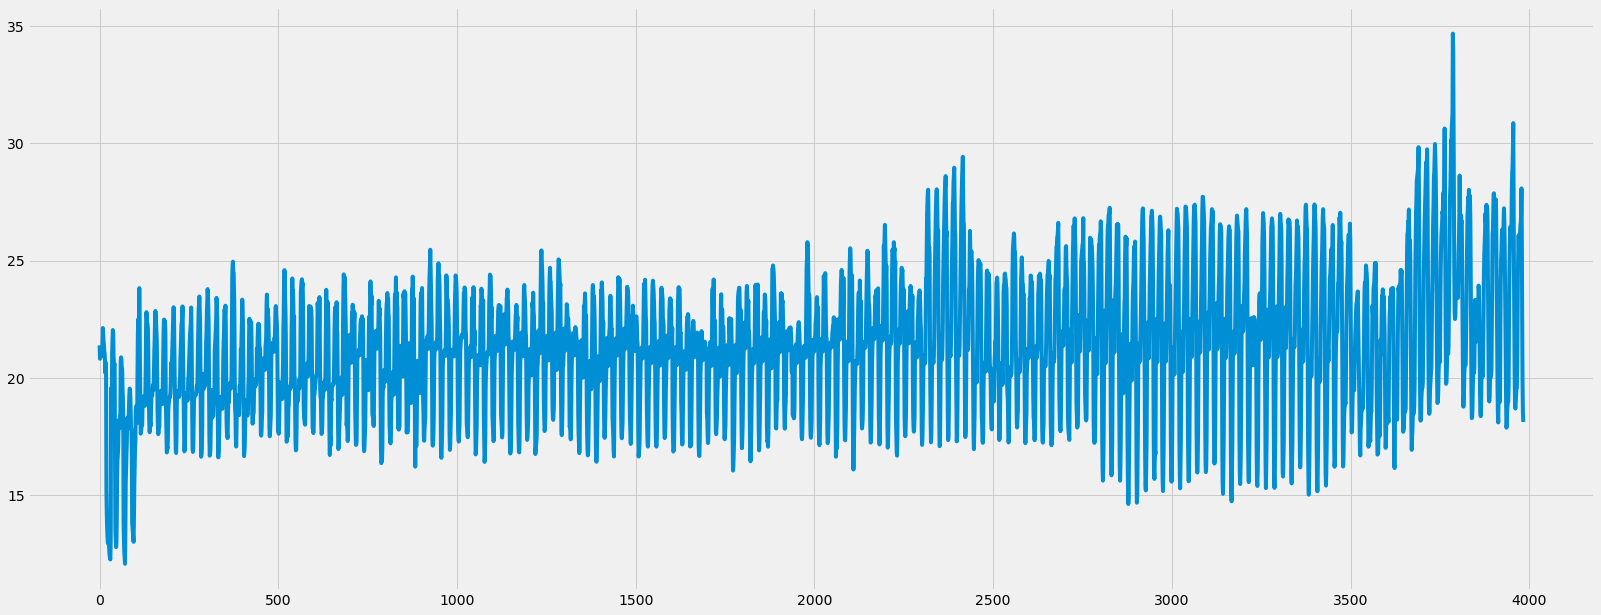

In [25]:
xdat2['Tair'].plot()
## little bit of trend going forward

<AxesSubplot:xlabel=' '>

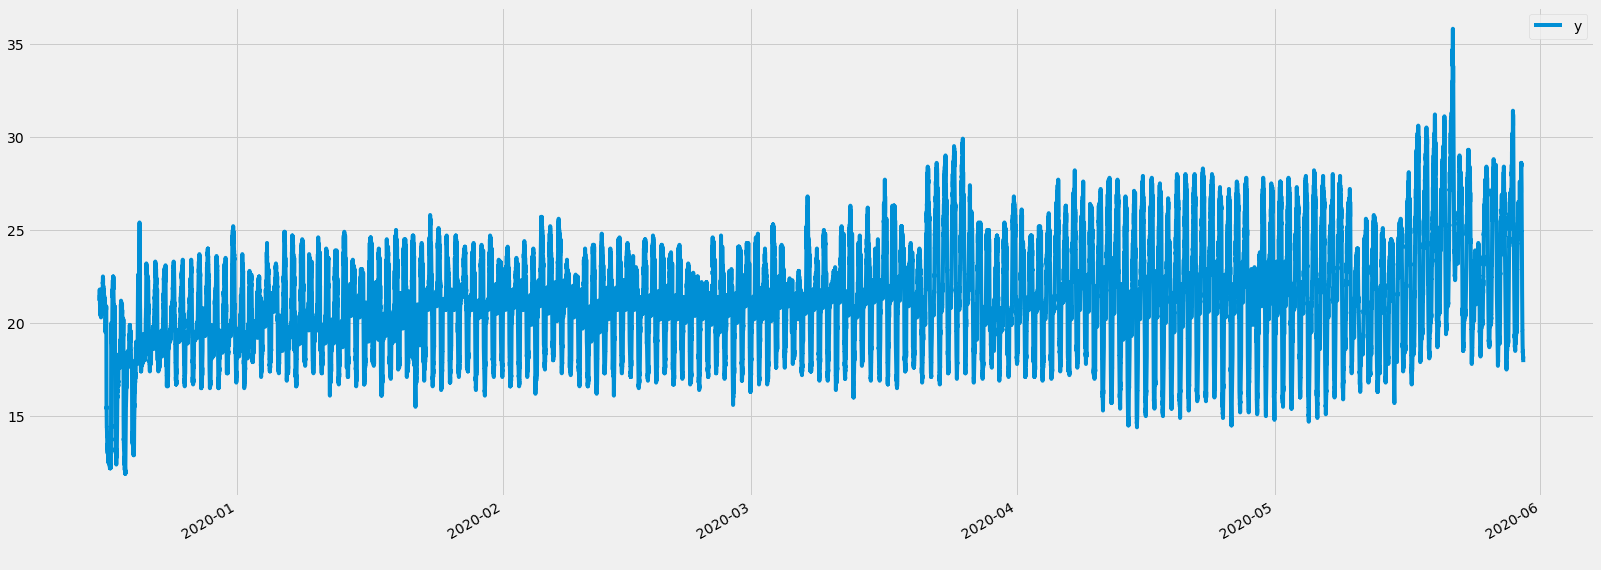

In [26]:
## timstamp column will always need to be called as ds
## target variable to be called as y
df = xdat[['time','Tair']].rename(columns = {'time':'ds','Tair':'y'})
df.set_index('ds').plot(xlabel=" ")

## Thumb rule:

        -- if you dont have 2 years of data: dont fit annual seasonality
        -- same, if no 2 weeks of data: dont fit weekly seasonality

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


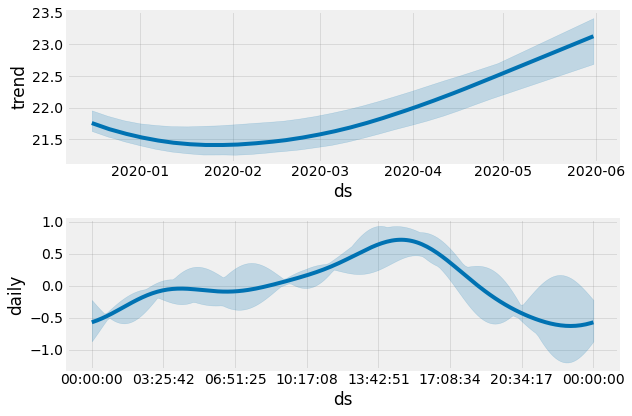

In [28]:
## this data has too many weeks, so prophet might me tempting to go for weekly seasonality
## but this is a physical phenommenon
## so weekly seasonality doesn't makes sense

%timeit 
m = Prophet(weekly_seasonality=False,
            interval_width=0.95,
            mcmc_samples=10)

with tf.device(device):
    m.fit(df)

with tf.device(device):
    future = m.make_future_dataframe(periods=24,freq='H')
    forecast = m.predict(future)
    m.plot_components(forecast)
    print()


## In daily seasonlaity
        -- we have a pattern that is fitted
        -- since it has zero in the CI:
         means that your preicted difference from your baseline is insignificant  

## Questions:

    -- What are tree based models in Time Series? -> Random forest, xgboost and all

    -- ARIMA might be better than tree based models when data is too less,
    so will exponential smoothing

In [ ]:
## without mcmc samples
m = Prophet(weekly_seasonality=False,
            interval_width=0.95,)

with tf.device(device):
    m.fit(df)
    future = m.make_future_dataframe(periods=24,freq='H')
    forecast = m.predict(future)
    m.plot_components(forecast)
    print()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
## Almost same trend with and without mcmc

In [25]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [26]:
## initial is how many hours you wanna cover
## period is by how much you wanna shift: say windowing technique only
## will shift by 24 hours in this case, fisrst 1,2 and shift so 2,3 and so on....

with tf.device(device):
    df_cv = cross_validation(m,initial="3700 hours", period = "24 hours", horizon="24 hours",)
    df_cv.head(10)

INFO:fbprophet:Making 11 forecasts with cutoffs between 2020-05-18 23:55:00.192000 and 2020-05-28 23:55:00.192000


  0%|          | 0/11 [00:00<?, ?it/s]

In [3]:
print(tf.config.list_physical_devices('GPU'))

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'list_physical_devices'